In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f"itos: {itos}")
print(f"stoi: {stoi}")

itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [98]:
block_size = 3 #context length - how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f"Context: {context}")
        # print(f"IX: {ix}")
        # print(''.join(itos[i] for i in context),'--->',itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [92]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [130]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [77]:
# -------------------- Clean Code ----------------------

In [131]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [154]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [155]:
sum(p.nelement() for p in parameters)

10281

In [156]:
for p in parameters:
    p.requires_grad = True

In [157]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [166]:
lri = []
lossi = []
stepi = []

for i in range(30000):

    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32,100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    # lr = lrs[i]
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad 
        
    #track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())




2.7580065727233887
2.589002847671509
2.1912684440612793
2.990386724472046
2.55556321144104
2.712874412536621
2.3135857582092285
2.4149727821350098
2.4404337406158447
2.5924370288848877
2.2509491443634033
2.422729015350342
2.2466537952423096
2.4268195629119873
2.2554802894592285
1.9983625411987305
2.6083106994628906
2.3945209980010986
2.7061755657196045
2.278531074523926
1.972419023513794
2.116370439529419
2.0527448654174805
2.0592386722564697
2.0665953159332275
2.133166551589966
2.040372371673584
2.679199457168579
2.3887507915496826
2.7260870933532715
2.387366771697998
2.0573785305023193
2.3676562309265137
2.3320415019989014
2.5351152420043945
2.7005960941314697
2.110806465148926
2.257889747619629
2.207974672317505
2.649989366531372
2.4820737838745117
2.3850317001342773
2.4780678749084473
2.340747117996216
2.2919530868530273
2.1885719299316406
2.436647653579712
2.4872677326202393
2.419499635696411
2.061225414276123
2.670079469680786
2.1912777423858643
2.480350971221924
1.91341352462768

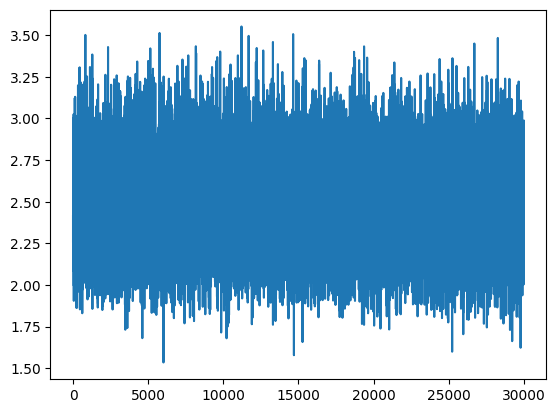

In [163]:
plt.plot(stepi,lossi)

In [167]:
#loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3008, grad_fn=<NllLossBackward0>)

In [168]:
#loss on dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3020, grad_fn=<NllLossBackward0>)

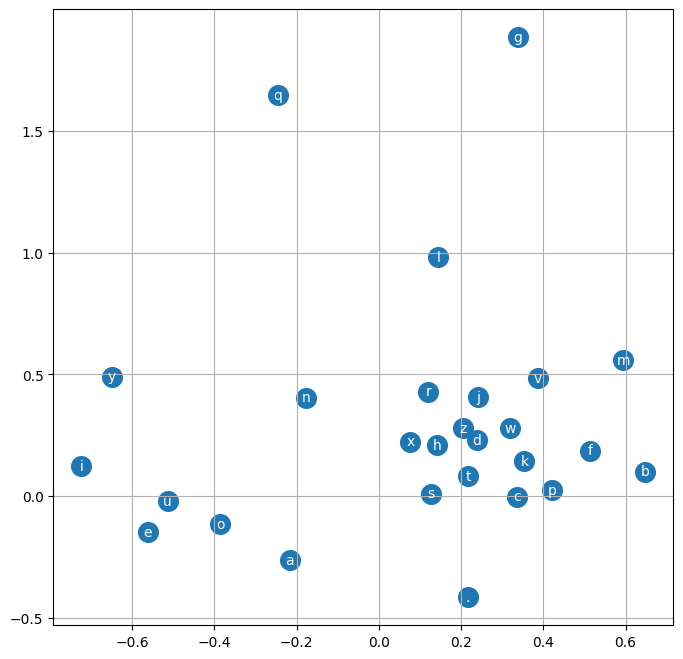

In [170]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va="center",color='white')
plt.grid('minor')